In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 76.50%
Success Probability Vector:
tensor([0.8654, 0.0027, 0.0418, 0.0049, 0.0194, 0.0044, 0.0032, 0.0056, 0.0445,
        0.0082], device='cuda:0')
Class 2 - Accuracy: 83.40%
Success Probability Vector:
tensor([2.1673e-03, 9.3214e-01, 7.1900e-04, 9.5739e-04, 4.0699e-04, 7.3522e-04,
        1.6432e-03, 5.1663e-04, 1.5839e-03, 5.9130e-02], device='cuda:0')
Class 3 - Accuracy: 69.10%
Success Probability Vector:
tensor([0.0217, 0.0013, 0.8826, 0.0080, 0.0385, 0.0134, 0.0204, 0.0082, 0.0032,
        0.0028], device='cuda:0')
Class 4 - Accuracy: 62.70%
Success Probability Vector:
tensor([0.0045, 0.0048, 0.0106, 0.7952, 0.0144, 0.1032, 0.0171, 0.0217, 0.0132,
        0.0154], device='cuda:0')
Class 5 - Accuracy: 75.20%
Success Probability Vector:
tensor([1.2473e-02, 7.8726e-04, 4.8350e-02, 1.2866e-02, 8.7405e-01, 5.8639e-03,
        1.2133e-02, 2.9787e-02, 2.5395e-03, 1.1520e-03], device='cuda:0')

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 1.0, Variance = 1.785657049402866e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 1 (Failed): Mean = 1.0, Variance = 1.882634698566958e-15, Min = 0.9999998211860657, Max = 1.0000001192092896
Class 2 (Successful): Mean = 1.0, Variance = 1.2383256405899368e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Failed): Mean = 1.0, Variance = 2.0331795583483593e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Successful): Mean = 1.0, Variance = 1.3592990978750327e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Failed): Mean = 1.0, Variance = 1.3495697598055146e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Successful): Mean = 1.0, Variance = 1.3053101707291093e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Failed): Mean = 1.0, Variance = 1.757256246439666e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 5 (Successful): Mean = 1.0, Variance = 1.513806060146

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'setting_3.pkl'
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[78.0, 82.0, 76.0, 83.0, 82.0, 84.0, 78.0, 84.0, 81.0, 84.0, 77.0, 77.0, 75.0, 80.0, 76.0, 81.0, 73.0, 86.0, 78.0, 84.0, 65.0, 69.0, 64.0, 69.0, 71.0, 68.0, 70.0, 67.0, 67.0, 61.0, 61.0, 55.0, 68.0, 68.0, 61.0, 67.0, 65.0, 69.0, 68.0, 65.0, 82.0, 72.0, 69.0, 71.0, 67.0, 72.0, 69.0, 68.0, 70.0, 68.0, 67.0, 75.0, 69.0, 73.0, 73.0, 73.0, 69.0, 70.0, 63.0, 65.0, 72.0, 80.0, 77.0, 77.0, 77.0, 78.0, 77.0, 77.0, 74.0, 78.0, 76.0, 81.0, 77.0, 78.0, 72.0, 76.0, 69.0, 77.0, 72.0, 74.0, 80.0, 88.0, 87.0, 80.0, 85.0, 86.0, 88.0, 87.0, 86.0, 88.0, 80.0, 90.0, 87.0, 83.0, 85.0, 85.0, 87.0, 92.0, 85.0, 84.0]
Before min/max/mean/std of accuracy
55.0 92.0 75.54 7.79


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 250, 1: 250}, 1: {0: 250, 1: 250}, 2: {0: 250, 1: 250}, 3: {0: 250, 1: 250}, 4: {0: 250, 1: 250}, 5: {0: 250, 1: 250}, 6: {0: 250, 1: 250}, 7: {0: 250, 1: 250}, 8: {0: 250, 1: 250}, 9: {0: 250, 1: 250}, 10: {0: 250, 1: 250}, 11: {0: 250, 1: 250}, 12: {0: 250, 1: 250}, 13: {0: 250, 1: 250}, 14: {0: 250, 1: 250}, 15: {0: 250, 1: 250}, 16: {0: 250, 1: 250}, 17: {0: 250, 1: 250}, 18: {0: 250, 1: 250}, 19: {0: 250, 1: 250}, 20: {2: 250, 3: 250}, 21: {2: 250, 3: 250}, 22: {2: 250, 3: 250}, 23: {2: 250, 3: 250}, 24: {2: 250, 3: 250}, 25: {2: 250, 3: 250}, 26: {2: 250, 3: 250}, 27: {2: 250, 3: 250}, 28: {2: 250, 3: 250}, 29: {2: 250, 3: 250}, 30: {2: 250, 3: 250}, 31: {2: 250, 3: 250}, 32: {2: 250, 3: 250}, 33: {2: 250, 3: 250}, 34: {2: 250, 3: 250}, 35: {2: 250, 3: 250}, 36: {2: 250, 3: 250}, 37: {2: 250, 3: 250}, 38: {2: 250, 3: 250}, 39: {2: 250, 3: 250}, 40: {4: 250, 5: 250}, 41: {4: 250, 5: 250}, 42: {4: 250, 5: 250}, 43: {4: 

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 50, 1: 50}, 1: {0: 50, 1: 50}, 2: {0: 50, 1: 50}, 3: {0: 50, 1: 50}, 4: {0: 50, 1: 50}, 5: {0: 50, 1: 50}, 6: {0: 50, 1: 50}, 7: {0: 50, 1: 50}, 8: {0: 50, 1: 50}, 9: {0: 50, 1: 50}, 10: {0: 50, 1: 50}, 11: {0: 50, 1: 50}, 12: {0: 50, 1: 50}, 13: {0: 50, 1: 50}, 14: {0: 50, 1: 50}, 15: {0: 50, 1: 50}, 16: {0: 50, 1: 50}, 17: {0: 50, 1: 50}, 18: {0: 50, 1: 50}, 19: {0: 50, 1: 50}, 20: {2: 50, 3: 50}, 21: {2: 50, 3: 50}, 22: {2: 50, 3: 50}, 23: {2: 50, 3: 50}, 24: {2: 50, 3: 50}, 25: {2: 50, 3: 50}, 26: {2: 50, 3: 50}, 27: {2: 50, 3: 50}, 28: {2: 50, 3: 50}, 29: {2: 50, 3: 50}, 30: {2: 50, 3: 50}, 31: {2: 50, 3: 50}, 32: {2: 50, 3: 50}, 33: {2: 50, 3: 50}, 34: {2: 50, 3: 50}, 35: {2: 50, 3: 50}, 36: {2: 50, 3: 50}, 37: {2: 50, 3: 50}, 38: {2: 50, 3: 50}, 39: {2: 50, 3: 50}, 40: {4: 50, 5: 50}, 41: {4: 50, 5: 50}, 42: {4: 50, 5: 50}, 43: {4: 50, 5: 50}, 44: {4: 50, 5: 50}, 45: {4: 50, 5: 50}, 46: {4: 50, 5: 50}, 47: {4: 50, 5: 

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([ 0.1313, -0.2099, -0.0227, -0.0054,  0.1184,  0.0090, -0.2321, -0.0430,
         0.0869,  0.1867], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([77.9692, 76.0826, 66.9759, 62.7859, 70.1227, 66.8039, 69.1499, 73.1772,
        73.8129, 73.0717], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000,  0.0685, -0.1830, -0.2106, -0.0954, -0.2281, -0.2013, -0.1153,
          0.0220, -0.1327],
        [ 0.0685,  1.0000, -0.2081, -0.1270, -0.2433, -0.1511, -0.0755, -0.1572,
         -0.1810,  0.0319],
        [-0.1830, -0.2081,  1.0000,  0.2142, -0.0657, -0.1649, -0.1073, -0.1313,
         -0.0718, -0.2198],
        [-0.2106, -0.1270,  0.2142,  1.0000, -0.1957, -0.0671, -0.1031, -0.0834,
         -0.1880, -0.1458],
        [-0.0954, -0.2433, -0.0657, -0.1957,  1.0000,  0.1941, -0.1237, -0.1537,
         -0.0859, -0.2

Weight norm of each class part of classifier
tensor([8.8300, 8.7225, 8.1839, 7.9238, 8.3739, 8.1734, 8.3156, 8.5544, 8.5914,
        8.5482], device='cuda:0', grad_fn=<SqrtBackward0>)


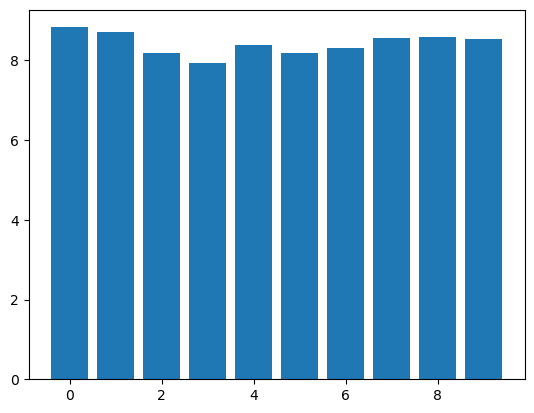

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

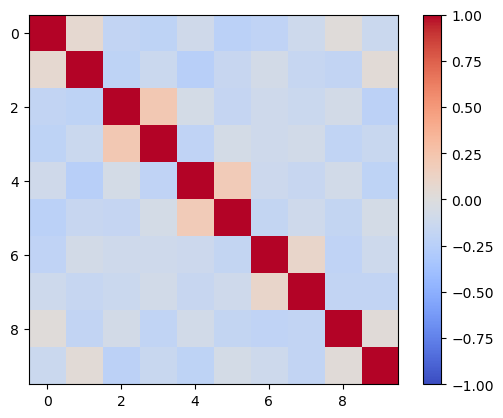

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.84905297, 1: 0.92294383, 2: 0.798307, 3: 0.7884612, 4: 0.8343419, 5: 0.8286858, 6: 0.8555657, 7: 0.84081703, 8: 0.8785379, 9: 0.9051951}
-------------------VAR-------------------
{0: 0.02440369, 1: 0.018608322, 2: 0.030982884, 3: 0.0330717, 4: 0.024850346, 5: 0.02742332, 6: 0.02614584, 7: 0.021545552, 8: 0.028570184, 9: 0.027304642}


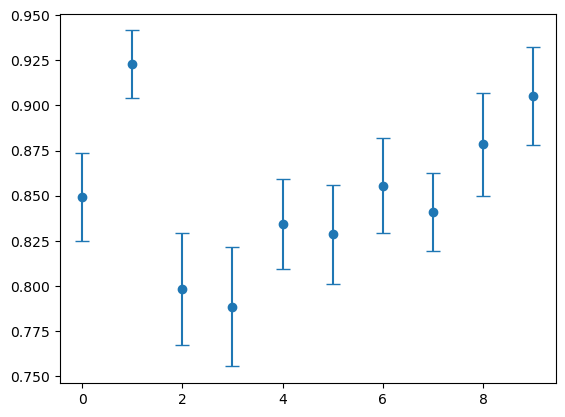

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'setting_3.pkl'
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5922e-04, 1.6663e-02,
        2.3619e-02, 0.0000e+00, 8.1059e-03, 0.0000e+00, 6.7440e-02, 0.0000e+00,
        1.1332e-01, 5.0779e-03, 9.4658e-04, 2.6705e-02, 0.0000e+00, 0.0000e+00,
        1.1318e-03, 1.2552e-03, 5.7298e-03, 0.0000e+00, 0.0000e+00, 3.4212e-03,
        1.7627e-03, 0.0000e+00, 1.4904e-03, 0.0000e+00, 1.7865e-04, 4.4804e-04,
        2.6915e-03, 4.3032e-04, 0.0000e+00, 2.2653e-05, 7.4471e-03, 8.1843e-08,
        1.4713e-05, 0.0000e+00, 1.3546e-03, 2.4132e-06, 2.5718e-01, 3.4477e-05,
        5.1176e-06, 3.6728e-02, 1.0693e-01, 0.0000e+00, 3.8002e-04, 0.0000e+00,
        1.3289e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7845e-03,
        9.3621e-02, 1.4005e-05, 0.0000e+00, 1.3011e-02, 8.4413e-03, 1.5456e-04,
        3.6156e-02, 6.4245e-02, 0.0000e+00, 1.8283e-04, 4.7937e-02, 3.1304e-03,
        2.2296e-03, 0.0000e+00, 0.0000e+

# Cosine Similarity of Centroid Vectors

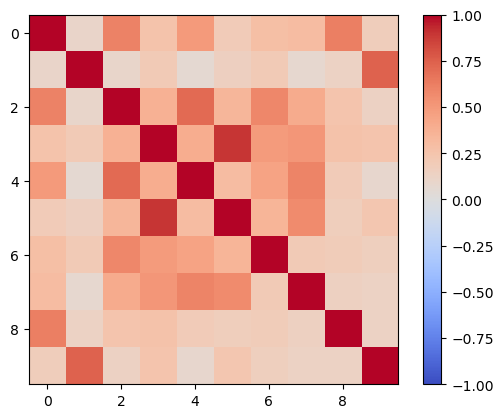

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.9999999  0.10714325 0.608262   0.25516707 0.4954493  0.1913772
  0.28288263 0.3011056  0.6171981  0.17517138]
 [0.10714325 1.         0.09496109 0.1968163  0.05816794 0.14943115
  0.20087442 0.07194856 0.12620404 0.7393375 ]
 [0.608262   0.09496109 1.         0.37194428 0.7032183  0.3361791
  0.5828946  0.40500933 0.24274653 0.13755926]
 [0.25516707 0.1968163  0.37194428 1.0000001  0.39146736 0.89198744
  0.489421   0.51462096 0.2579801  0.2487139 ]
 [0.4954493  0.05816794 0.7032183  0.39146736 1.         0.2969344
  0.4465139  0.5966451  0.18926388 0.08577283]
 [0.1913772  0.14943115 0.3361791  0.89198744 0.2969344  1.
  0.34427053 0.56809163 0.17007986 0.23271225]
 [0.28288263 0.20087442 0.5828946  0.489421   0.4465139  0.34427053
  0.99999994 0.19613713 0.18086992 0.15847617]
 [0.3011056  0.07194856 0.40500933 0.51462096 0.5966451  0.56809163
  0.19613713 0.99999994 0.14147776 0.13158228]
 [0.6171981  0.12620404 0.24274653 0.2579801  0.18926388 0.17007986

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.5650, 0.7380, 0.6480, 0.5543, 0.6159, 0.6027, 0.6864, 0.6211, 0.7057,
        0.6873], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.5650, 0.7380, 0.6480, 0.5543, 0.6159, 0.6027, 0.6864, 0.6211, 0.7057,
        0.6873], device='cuda:0', grad_fn=<DiagonalBackward0>)


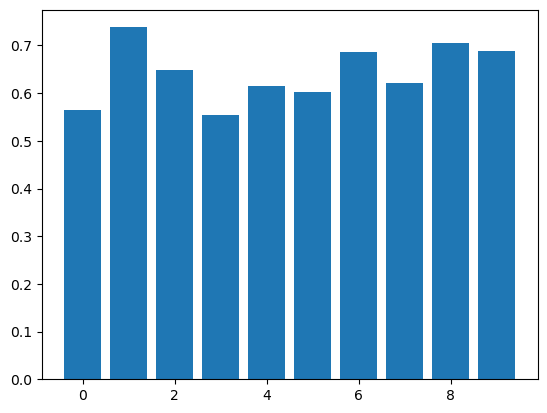

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Singular Value Analysis

Files already downloaded and verified
Files already downloaded and verified
['2.924', '2.848', '2.607', '2.401', '2.220', '2.096', '1.990', '1.732', '1.655', '1.538', '1.328', '1.098', '1.062', '1.052', '1.040', '1.039', '1.032', '1.027', '1.023', '1.017', '1.012', '1.005', '0.998', '0.993', '0.993', '0.987', '0.983', '0.976', '0.970', '0.965', '0.962', '0.958', '0.954', '0.951', '0.949', '0.945', '0.938', '0.937', '0.933', '0.933', '0.926', '0.923', '0.918', '0.915', '0.914', '0.907', '0.907', '0.900', '0.898', '0.897', '0.893', '0.889', '0.886', '0.883', '0.878', '0.876', '0.874', '0.871', '0.867', '0.866', '0.865', '0.858', '0.856', '0.852', '0.850', '0.848', '0.846', '0.844', '0.839', '0.837', '0.833', '0.832', '0.830', '0.826', '0.824', '0.821', '0.817', '0.813', '0.811', '0.807', '0.806', '0.804', '0.800', '0.800', '0.799', '0.796', '0.792', '0.789', '0.786', '0.785', '0.784', '0.780', '0.777', '0.776', '0.771', '0.769', '0.767', '0.766', '0.764', '0.761', '0.758', '0.757', '0.75

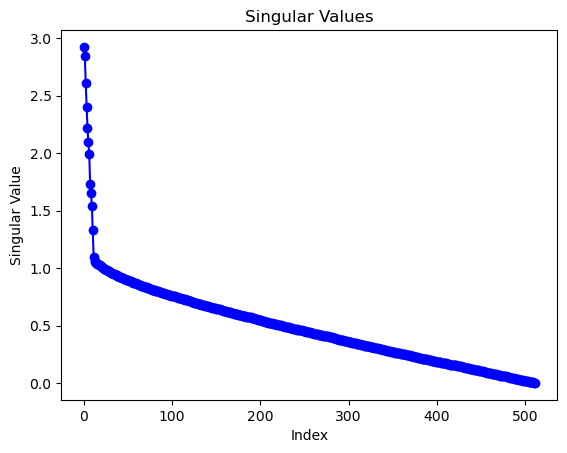

In [23]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()
                
                info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

                # Compute the singular value decomposition (SVD)
                _, s, _ = torch.svd(info_param[0])

                # Sort the singular values in descending order and store them in a list
                sorted_s = sorted(s.tolist(), reverse=True)
                
                
                print(["{:.3f}".format(num) for num in sorted_s])
                # Create a list of indices for the singular values
                indices = list(range(len(sorted_s)))

                # Plot the singular values with their indices
                plt.plot(indices, sorted_s, marker='o', linestyle='-', color='b')
                plt.xlabel('Index')
                plt.ylabel('Singular Value')
                plt.title('Singular Values')

                # Set x-axis ticks to display only integer values
#                 plt.xticks(indices)

                plt.show()

